In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import random
import math

import tensorflow_datasets as tfds
from tensorflow import keras
from keras import layers
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator

from keras.layers.convolutional.conv2d_transpose import Conv2DTranspose
from keras.layers.reshaping.up_sampling2d import UpSampling2D
from sklearn.preprocessing import StandardScaler

import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

2023-03-31 21:12:18.646889: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-31 21:12:20.612994: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/global/home/users/agoh/anaconda3/envs/tf/lib/
2023-03-31 21:12:20.613344: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/global/home/users/agoh/anaconda3/envs/tf/lib/
2023-03-31 21:12:20.613359

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  4
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


## MNIST Dataset

In [ ]:
# Prepare the dataset. We use both the training & test MNIST digits.

(x_train, _), (x_test, _) = keras.datasets.mnist.load_data()

all_digits = np.concatenate([x_train, x_test])
all_digits = np.array(all_digits.astype("float32")) / 255.0
all_digits = np.reshape(all_digits, (-1, 28, 28, 1))

mnist_train = np.array(x_train.astype("float32")) / 255.0
mnist_train = np.reshape(mnist_train, (-1, 28, 28, 1))

mnist_test = x_test.astype("float32") / 255.0
mnist_test = np.reshape(mnist_test, (-1, 28, 28, 1))



## Synthetic Data

'for image in images:\n    plt.figure()\n    plt.imshow(image.reshape(shape[0], shape[1]))\n'

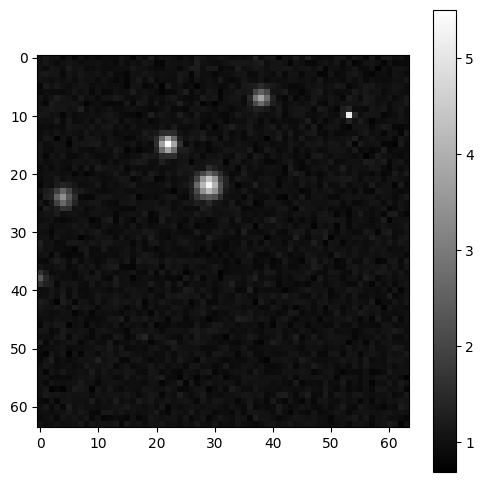

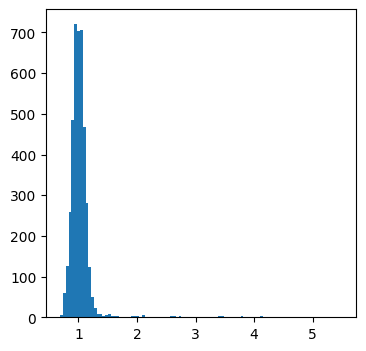

In [ ]:
def make_image(shape, noise_mean = 1, noise_std = 1, num_obj_min = 1, num_obj_max = 20):

    rows = shape[0]
    cols = shape[1]

    # add noise
    num_pixels = sum(shape)
    noise_layer = np.random.normal(loc = noise_mean, scale = noise_std, size = shape)
    image = noise_layer

    num_obj = np.random.randint(num_obj_min, num_obj_max)


    for i in range(num_obj):
        sigma = np.random.uniform(0.4,1.5)
        amp = np.random.uniform(1,5)
        x0, y0 = np.random.randint(0, rows), np.random.randint(0, cols)
        x, y = np.meshgrid(np.arange(cols), np.arange(rows))
        gaussian = amp*np.exp(-((x-x0)**2 + (y-y0)**2) / (2*sigma**2))

        image += gaussian

    errors = np.sqrt(image)

    image = np.array(image).reshape(shape[0], shape[1],1)
    errors = np.array(errors).reshape(shape[0], shape[1],1)


    return image, errors

# VISUALIZE

# INIT VARIABLES
shape = (64,64)
noise_mean = 1
noise_std = 0.1
num_obj_min = 1
num_obj_max = 9

# test plot
image, errors = make_image(shape, noise_mean, noise_std, num_obj_min, num_obj_max)
plt.figure(figsize = (6,6))
plt.imshow(image.reshape(shape[0], shape[1]), cmap = 'gray')
plt.colorbar()

# histogram
image_flatten = np.array(image).flatten()
np.shape(image_flatten)
plt.figure(figsize = (4,4))
histogram = plt.hist(image_flatten, density = False, bins = 100)


# batches
def make_image_batch(batch_size, shape, noise_mean, noise_std, num_obj_min, num_obj_max):
    images = []
    errors = []
    for i in range(batch_size):
        image, err = make_image(shape, noise_mean, noise_std, num_obj_min, num_obj_max)
        images.append(image)
        errors.append(err)

    return np.array(images), np.array(errors)

batch_size = 4
images, errors = make_image_batch(batch_size, shape, noise_mean, noise_std, num_obj_min, num_obj_max)

'''for image in images:
    plt.figure()
    plt.imshow(image.reshape(shape[0], shape[1]))
'''


In [ ]:
# load synthetic images into memory

num_imgs = 50000

synth_imgs = make_image_batch(num_imgs, shape, noise_mean, noise_std, num_obj_min, num_obj_max)
print(np.shape(synth_imgs))

# sklearn standard scaler
synth_imgs, _ = synth_imgs
flattened_synth_imgs = np.reshape(synth_imgs, (num_imgs, 64*64))
scaler = StandardScaler()
scaler.fit(flattened_synth_imgs)
synth_imgs_scaled = scaler.transform(flattened_synth_imgs)
synth_imgs_scaled = np.reshape(synth_imgs_scaled, (num_imgs,64,64,1))

synth_train = synth_imgs_scaled[0:int(num_imgs*0.9)]
synth_test = synth_imgs_scaled[int(num_imgs*0.9):]
print(np.shape(synth_train))
print(np.shape(synth_test))



(2, 50000, 64, 64, 1)
(45000, 64, 64, 1)
(5000, 64, 64, 1)


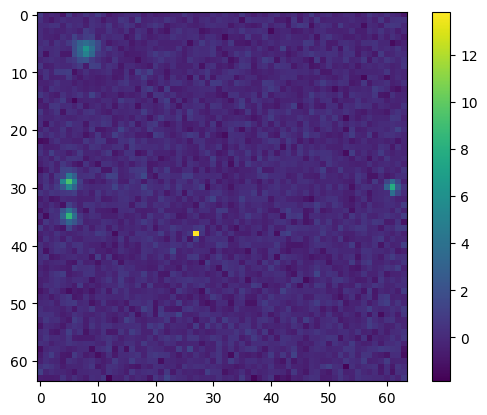

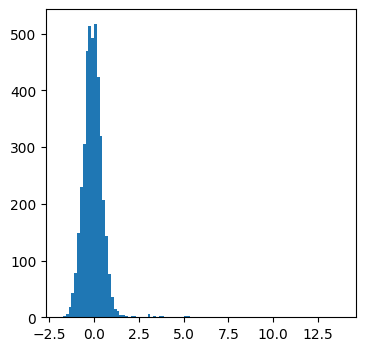

In [ ]:
# test scaled images

image = synth_imgs_scaled[1]

plt.imshow(image.reshape(64,64))
plt.colorbar()

# histogram
image_flatten = np.array(image).flatten()
np.shape(image_flatten)
plt.figure(figsize = (4,4))
histogram = plt.hist(image_flatten, density = False, bins = 100)


## BVAE

In [ ]:
class BVAE(keras.Model):

    def bvae_compile(self, optimizer, encoder, decoder, beta_r, **kwargs):
        self.compile(optimizer = optimizer)
        self.encoder = encoder
        self.decoder = decoder
        self.beta_r = beta_r
        self.kl_loss_tracker = keras.metrics.Mean(name = "kl_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    @tf.function
    def train_step(self, data):

        xpair, errs = data
        x, logbeta = xpair

        with tf.GradientTape() as tape:
            # encode batch to latent vectors
            reconstruction, z_mean, z_log_var, z = self(xpair, training = True)
            # decode batch from z
            # reconstruction = self.decoder([z, logbeta])

            """Weighted MSE"""
            #difference = tf.math.subtract(x, reconstruction)
            # weighted
            #reconstruction_loss = K.mean(K.square(tf.multiply(difference, tf.math.reciprocal(errs))))
            # non weighted
            # reconstruction_loss = K.mean(K.square(x - reconstruction))
            reconstruction_loss = tf.keras.losses.logcosh(x, reconstruction)

            """KL Loss"""
            # calculate kl loss across latent variables of each image in batch
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            # sum loss over latent dimensions, calculate mean of batch
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis = 1))
            # calculate total loss, include B regularizzer
            total_loss = reconstruction_loss + tf.reduce_mean(tf.exp(logbeta)*np.log(10.)) * kl_loss * self.beta_r

        # grad loss wrt weights
        grads = tape.gradient(total_loss, self.trainable_weights)
        # apply gradients to weights
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        # update state of trackers
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def test_step(self, data):
        # Unpack the data
        xpair, errs = data
        x, logbeta = xpair

        # Compute predictions
        reconstruction, z_mean, z_log_var, z = self(xpair, training = True)

        """Weighted MSE"""
        #difference = tf.math.subtract(x, reconstruction)
        # weighted
        #reconstruction_loss = K.mean(K.square(tf.multiply(difference, tf.math.reciprocal(errs))))
        # non weighted
        # reconstruction_loss = K.mean(K.square(x - reconstruction))
        reconstruction_loss = tf.keras.losses.logcosh(x, reconstruction)

        # calculate kl loss across latent variables of each image in batch
        kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
        # sum loss over latent dimensions, calculate mean of batch
        kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis = 1))

        # calculate total loss, include B regularizzer
        total_loss = reconstruction_loss + tf.reduce_mean(tf.exp(logbeta)*np.log(10.)) * kl_loss * self.beta_r

        self.total_loss_tracker.reset_states()
        self.reconstruction_loss_tracker.reset_states()
        self.kl_loss_tracker.reset_states()

        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)

        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


    def predict_MLE(self, data):
        xpair, err = data
        x, logbeta = xpair
        z_mean, z_log_var, z = self.encoder(xpair, training = False)
        reconstruction = self.decoder([z_mean, logbeta])

        return reconstruction


In [ ]:
#sampling
latent_dim = 128
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                                mean=0., stddev=0.1)
    return z_mean + K.exp(0.5*z_log_var) * epsilon


# build and compile bvae
def build_and_compile_bvae(input_shape,
                           encoder_conv_layers = [128,64],
                           encoder_dense_layers = [32],
                           decoder_dense_layers = [32],
                           decoder_conv_layers = [64, 128],
                           latent_dim = 4,
                           dropout = 0,
                           beta_r = 0.1,
                           optimizer=keras.optimizers.Adam(),
                           learning_rate = 0.001,
                           verbose = True):


    # encoder
    inputs = tf.keras.Input(shape = input_shape, name = 'inputs')
    logbeta = tf.keras.Input(shape = (1,), name = 'logbeta_inputs')
    layer = inputs

    # enc_conv layers
    for layer_size in encoder_conv_layers:
        layer = layers.Conv2D(layer_size, (3,3), padding = 'same')(layer)
        layer = keras.layers.LeakyReLU(0.1)(layer)
        layer = keras.layers.BatchNormalization()(layer)
        if dropout > 0:
            layer = keras.layers.Dropout(dropout)(layer)

    # pool
    layer = keras.layers.MaxPooling2D(2,2)(layer)
    layer = layers.Conv2D(encoder_conv_layers[-1], (3,3), padding = 'same')(layer)
    layer = keras.layers.LeakyReLU(0.1)(layer)
    layer = keras.layers.BatchNormalization()(layer)
    layer = keras.layers.MaxPooling2D(2,2)(layer)
    shape_before_flatten = K.int_shape(layer)[1:]

    # flatten
    layer = keras.layers.Flatten()(layer)
    # concat
    layer = keras.layers.Concatenate(axis = 1)([layer, logbeta])

    # enc_dense layers
    for size in encoder_dense_layers:
        layer = keras.layers.Dense(size)(layer)
        layer = keras.layers.LeakyReLU(0.1)(layer)
        if dropout > 0:
            layer = keras.layers.Dropout(dropout)(layer)

    # encode to z
    z_mean = keras.layers.Dense(latent_dim, name='z_mean')(layer)
    z_log_var = keras.layers.Dense(latent_dim, name='z_log_var')(layer)

    layer = tf.stack([z_mean,z_log_var])
    z = tfpl.DistributionLambda(make_distribution_fn = lambda t: tfd.MultivariateNormalDiag(t[0],tf.exp(t[1]/2)),
                                    name="encoder_gauss_distribution")(layer)

    encoder = keras.Model([inputs,logbeta], [z_mean, z_log_var, z], name= 'encoder')
    if verbose:
        encoder.summary()

    # Decoder
    latent_inputs_gauss = keras.Input(shape=(latent_dim,), name='z_sampling')
    logbeta_decoder = keras.Input(shape=(1,), name='logbeta_decoder')

    layer = keras.layers.Concatenate(axis = 1)([latent_inputs_gauss,logbeta_decoder])

    # dec_dense layers
    for size in decoder_dense_layers:
        layer = keras.layers.Dense(size)(layer)
        layer = keras.layers.LeakyReLU(0.1)(layer)
        if dropout > 0:
            layer = keras.layers.Dropout(dropout)(layer)

    # intermediate layer
    layer = keras.layers.Dense(shape_before_flatten[0]*shape_before_flatten[1]*decoder_conv_layers[0])(layer)
    # reshape
    layer = keras.layers.Reshape(target_shape = shape_before_flatten)(layer)

    # upscale
    layer = keras.layers.UpSampling2D((2,2))(layer)
    layer = layers.Conv2DTranspose(decoder_conv_layers[0], (3,3), padding = 'same')(layer)
    layer = keras.layers.LeakyReLU(0.1)(layer)
    layer = keras.layers.BatchNormalization()(layer)
    layer = keras.layers.UpSampling2D((2,2))(layer)

    # dec_conv layers
    for layer_size in decoder_conv_layers:
        layer = layers.Conv2DTranspose(layer_size, (3,3), padding = 'same')(layer)
        layer = keras.layers.LeakyReLU(0.1)(layer)
        layer = keras.layers.BatchNormalization()(layer)
        if dropout > 0:
            layer = keras.layers.Dropout(dropout)(layer)

    # final layer
    decoded = layers.Conv2D(1, (3,3), padding = 'same')(layer)

    decoder = keras.Model([latent_inputs_gauss, logbeta_decoder], decoded, name = 'decoder')

    if verbose:
        decoder.summary()


    outputs = decoder([encoder([inputs,logbeta])[2],logbeta])
    vae = BVAE([inputs, logbeta], [outputs, z_mean, z_log_var, z], name = 'BVAE')
    vae.bvae_compile(optimizer = optimizer, encoder = encoder, decoder = decoder, beta_r = beta_r)
    K.set_value(vae.optimizer.learning_rate, learning_rate)

    return vae, encoder, decoder

2023-03-25 23:48:11.091228: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-25 23:48:13.680780: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9159 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:3b:00.0, compute capability: 6.1
2023-03-25 23:48:13.681751: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9189 MB memory:  -> device: 1, name: NVIDIA TITAN X (Pascal), pci bus id: 0000:5e:00.0, compute capability: 6.1
2023-03-25 23:48:13.682415: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1613] Created device /job:localhost/replica:0/task:0/de

## Beta-VAE run

In [ ]:
# WANDB

# start run, tracking hyperparameters
run = wandb.init(mode = "disabled",
    #set project
    project = "bvae_synth_data",

    config = {
        "epochs": 10,
        "batch_size": 128,
        "latent_dim": 64,
        "encoder_conv_layers": [128,128],
        "encoder_dense_layers": [80],
        "decoder_dense_layers" : [80],
        "decoder_conv_layers": [128, 128],
        "dropout": 0.1,
        "input_shape": (32,32,1),
        "shape": (32,32),
        "logbeta_min": -11,
        "logbeta_max": 0,
        "noise_mean": 1,
        "noise_std": 0.1,
        "num_obj_min": 1,
        "num_obj_max": 10,
        "steps_per_epoch": 1000,
        "beta_r": 0.0003,
        "learning_rate": 0.0005
    }
)

config = wandb.config


# build and compile
shape = config.input_shape
vae, encoder, decoder = build_and_compile_bvae(input_shape = config.input_shape,
                                               encoder_conv_layers = config.encoder_conv_layers,
                                               encoder_dense_layers = config.encoder_dense_layers,
                                               decoder_dense_layers = config.decoder_dense_layers,
                                               decoder_conv_layers = config.decoder_conv_layers,
                                               latent_dim = config.latent_dim,
                                               dropout = config.dropout,
                                               beta_r = config.beta_r,
                                               optimizer = keras.optimizers.Adam(),
                                               learning_rate = config.learning_rate
                                               )

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


Instructions for updating:
`scale_identity_multiplier` is deprecated; please combine it into `scale_diag` directly instead.
Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 inputs (InputLayer)            [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 128)  1280        ['inputs[0][0]']                 
                                                                                                  
 leaky_re_lu (LeakyReLU)        (None, 32, 32, 128)  0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 128)  512        ['

In [ ]:
# generate batches of synthetic data
shape = config.shape

logbeta_min = config.logbeta_min
logbeta_max = config.logbeta_max

noise_mean = config.noise_mean
noise_std = config.noise_std
num_obj_min = config.num_obj_min
num_obj_max = config.num_obj_max
batch_size = config.batch_size

def generate_synth_batch(batch_size, logbeta_min=logbeta_min, logbeta_max=logbeta_max):
    while True:
        images, errors = make_image_batch(batch_size, shape, noise_mean, noise_std, num_obj_min, num_obj_max)
        logbetas = np.random.uniform(low=logbeta_min, high=logbeta_max, size = batch_size)
        yield ([images, logbetas], errors)


# generate batches of mnist data

def generate_mnist_batch_train(batch_size,logbeta_min=logbeta_min,logbeta_max=logbeta_max):
  idx = 0
  while True:
    images = mnist_train[idx:idx+batch_size]
    logbetas = np.random.uniform(low=logbeta_min, high=logbeta_max, size=batch_size)
    images = np.array(images)
    logbetas = np.array(logbetas)
    errors = np.ones_like(images)
    yield ([images, logbetas], errors)
    idx += batch_size
    if idx + batch_size >= len(mnist_train):
      idx=0

def generate_mnist_batch_test(batch_size,logbeta_min=logbeta_min,logbeta_max=logbeta_max):
  idx = 0
  while True:
    images = mnist_test[idx:idx+batch_size]
    logbetas = np.random.uniform(low=logbeta_min, high=logbeta_max, size=batch_size)
    images = np.array(images)
    logbetas = np.array(logbetas)
    errors = np.ones_like(images)
    yield ([images, logbetas], errors)
    idx += batch_size
    if idx + batch_size >= len(mnist_test):
      idx=0



epochs = config.epochs
steps_per_epoch = config.steps_per_epoch
batch_size = config.batch_size

# FIT SYNTHETIC
history = vae.fit(x = generate_synth_batch(batch_size, logbeta_min, logbeta_max),
                  epochs = epochs,
                  steps_per_epoch = steps_per_epoch,
                  callbacks = [WandbMetricsLogger(log_freq=5),
                    WandbModelCheckpoint("models/bvae_model/beta_vae_weights", save_weights_only = True, monitor = 'loss')])

mnist_steps = 938
mnist_val_steps = 156

# FIT MNIST
'''history = vae.fit(x = generate_mnist_batch_train(batch_size, logbeta_min, logbeta_max),
                  epochs = epochs,
                  steps_per_epoch = mnist_steps,
                  validation_data = generate_mnist_batch_test(batch_size, logbeta_min, logbeta_max),
                  validation_steps = mnist_val_steps,
                  callbacks = [WandbMetricsLogger(log_freq=5),
                    WandbModelCheckpoint("models/bvae_model/beta_vae_weights", save_weights_only = True, monitor = 'loss')])'''

wandb.finish()



Epoch 1/10


2023-03-24 19:37:18.879166: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/BVAE/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-03-24 19:37:19.889446: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8100
2023-03-24 19:37:21.631084: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7fded4010e80 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-03-24 19:37:21.631170: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA TITAN Xp, Compute Capability 6.1
2023-03-24 19:37:21.631193: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (1): NVIDIA TITAN X (Pascal), Compute Capability 6.1
2023-03-24 19:37:21.631212: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (

1000/1000 [==============================] - 135s 122ms/step - loss: 0.1282 - reconstruction_loss: 0.0702 - kl_loss: 64.0127
Epoch 2/10
1000/1000 [==============================] - 120s 120ms/step - loss: 0.0472 - reconstruction_loss: 0.0414 - kl_loss: 49.7039
Epoch 3/10
1000/1000 [==============================] - 119s 119ms/step - loss: 0.0393 - reconstruction_loss: 0.0343 - kl_loss: 62.9561
Epoch 4/10
1000/1000 [==============================] - 121s 121ms/step - loss: 0.0363 - reconstruction_loss: 0.0318 - kl_loss: 66.4678
Epoch 5/10
1000/1000 [==============================] - 118s 118ms/step - loss: 0.0350 - reconstruction_loss: 0.0305 - kl_loss: 67.4163
Epoch 6/10
1000/1000 [==============================] - 122s 122ms/step - loss: 0.0340 - reconstruction_loss: 0.0296 - kl_loss: 67.9102
Epoch 7/10
1000/1000 [==============================] - 120s 120ms/step - loss: 0.0332 - reconstruction_loss: 0.0288 - kl_loss: 67.6568
Epoch 8/10
1000/1000 [==============================] - 120

In [ ]:
wandb.finish()

In [ ]:
# load weights



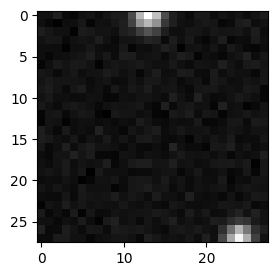

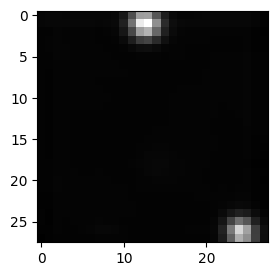

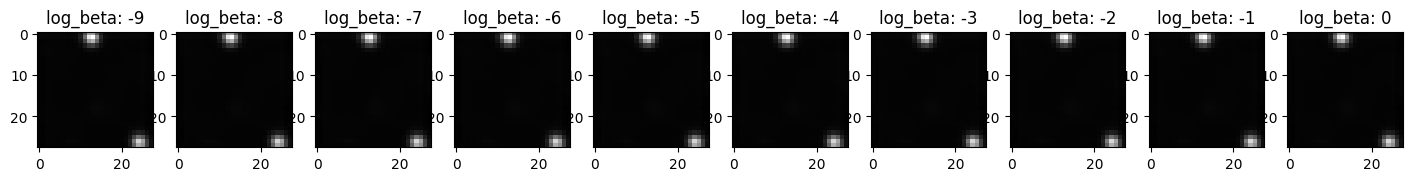

In [ ]:
# predict MLE synth

image, error = make_image_batch(1, shape, noise_mean, noise_std, num_obj_min, num_obj_max)

plt.figure(figsize = (3,3))
plt.imshow(np.array(image).reshape(config.shape), cmap='gray')

image = np.array(image)
error = np.array(error)

logbeta = 0
logbeta = np.array([logbeta])

xpair = (image, logbeta)
data = (xpair, error)

reconstruction = vae.predict_MLE(data)
recon = np.array(reconstruction)

plt.figure(figsize = (3,3))
plt.imshow(recon.reshape(config.shape), cmap = 'gray')

logbetas = [-9,-8, -7, -6, -5, -4, -3, -2, -1, 0]


plt.figure(figsize = (23,10))
for idx, logbeta in enumerate(logbetas):
    ax = plt.subplot(2, len(logbetas)+3, idx+1)
    logbeta = np.array([logbeta])
    xpair = (image, logbeta)
    data = (xpair, error)

    reconstruction = vae.predict_MLE(data)
    recon = np.array(reconstruction)

    plt.title('log_beta: {}'.format(logbeta[0]))
    plt.imshow(recon.reshape(config.shape), cmap = 'gray')





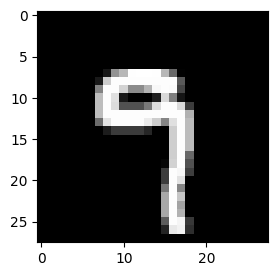

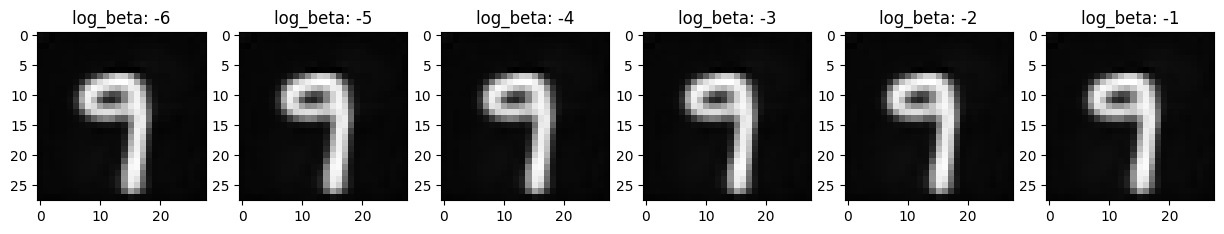

In [ ]:
# predict MLE mnist

rand_idx = np.random.randint(low = 0, high = 60000)
image = np.array([mnist_train[rand_idx]])
errors = np.array([np.ones_like(image)])

plt.figure(figsize = (3,3))
plt.imshow(np.array(image).reshape(config.shape), cmap = 'gray')

image = np.array(image)
error = np.array(errors)


logbetas = [-6, -5, -4, -3, -2, -1, 0]

plt.figure(figsize = (23,10))
for idx, logbeta in enumerate(logbetas):
    ax = plt.subplot(2, len(logbetas)+3, idx+1)
    logbeta = np.array([logbeta])
    xpair = (image, logbeta)
    data = (xpair, error)

    reconstruction = vae.predict_MLE(data)
    recon = np.array(reconstruction)

    plt.title('log_beta: {}'.format(logbeta[0]))
    plt.imshow(recon.reshape(config.shape), cmap = 'gray')

## Autoencoder w/ Synthetic Data

In [ ]:
import tensorflow as tf
import keras


input_shape = (64,64,1)
encoding_dim = 128

# autoencoder architecture

# encoder
input = keras.Input(shape = input_shape)
conv_1 = keras.layers.Conv2D(256, (3,3), activation = 'relu', padding = 'same')(input)
pool_1 = keras.layers.MaxPooling2D((2,2), padding = 'same')(conv_1)
conv_2 = keras.layers.Conv2D(128, (3,3), activation = 'relu', padding = 'same')(pool_1)
pool_2 = keras.layers.MaxPooling2D((2,2), padding = 'same')(conv_2)
flatten_1 = keras.layers.Flatten()(pool_2)
encoded = keras.layers.Dense(encoding_dim, activation = 'relu')(flatten_1)


# decoder
dense_1 = keras.layers.Dense(16*16*64, activation = 'relu')(encoded)
reshape = keras.layers.Reshape(target_shape = (16,16,64))(dense_1)
deconv_1 = keras.layers.Conv2DTranspose(128, (3,3), activation = 'relu', padding = 'same')(reshape)
upsample_1 = keras.layers.UpSampling2D((2,2))(deconv_1)
deconv_2 = keras.layers.Conv2DTranspose(256, (3,3), activation = 'relu', padding = 'same')(upsample_1)
upsample_2 = keras.layers.UpSampling2D((2,2))(deconv_2)
decoded = keras.layers.Conv2DTranspose(1, (3,3), padding = 'same')(upsample_2)

autoencoder_C = keras.Model(input, decoded)

# set learning rate / compile
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
autoencoder_C.compile(optimizer=optimizer, loss='mean_squared_error')

autoencoder_C.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 64, 64, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 256)       2560      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 32, 32, 256)      0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (None, 32, 32, 128)       295040    
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 16, 16, 128)      0         
 2D)                                                             
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0   

In [ ]:
epochs = 12
batch_size = 64

#fit autoencoder compare input X_train with output X_train
autoencoder_C.fit(synth_train, synth_train, epochs = epochs, batch_size = batch_size, shuffle = True,
                  validation_data = (synth_test, synth_test))


KeyboardInterrupt: 

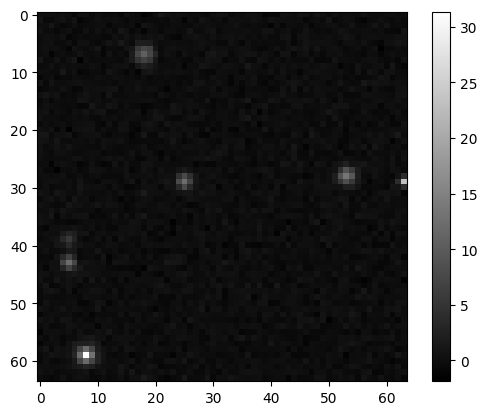

1/1 [==============================] - 0s 33ms/step


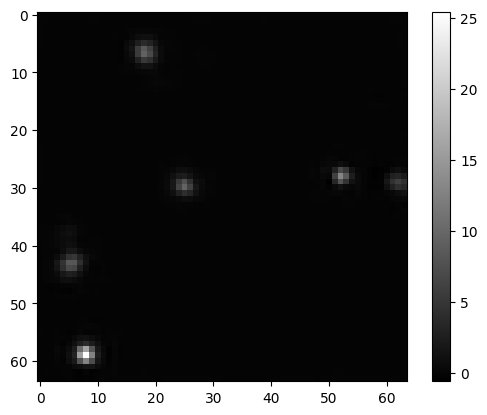

In [ ]:
# test reconstruction

index = random.randint(0, 5000)

plt.imshow(synth_test[index].reshape(64,64), cmap = 'gray')
plt.colorbar()
plt.show()

test_img = synth_test[index].reshape(1,64,64,1)

decoded_img = autoencoder_C.predict(test_img)

plt.imshow(decoded_img.reshape(64,64), cmap = 'gray')
plt.colorbar()
plt.show()